In [12]:

import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys

dt = 0.1
tstart = 0
tlim = 200
t = np.arange(tstart, tlim, 1)


d_cut = 160

ndiv = 1/dt

### keep it always starting at 0
tmoh = np.arange(0, tlim, dt)

N_city = 1

PHU_path = '/Users/sudhipv/documents/sum_of_sigmoid/PHU_Data/'
figpath = '/Users/sudhipv/documents/sum_of_sigmoid/figs/predictions/real'
datapath = '/Users/sudhipv/documents/sum_of_sigmoid/data'

Data = np.zeros([365,4])

files = os.listdir(PHU_path)

target_file1 = f'{PHU_path}/30-Toronto.csv'
target_file2 = f'{PHU_path}/34-York.csv'
target_file3 = f'{PHU_path}/04-Durham.csv'
target_file4 = f'{PHU_path}/22-PeelRegion.csv'

Data[:,0] = np.genfromtxt(target_file1, delimiter=',')
Data[:,1] = np.genfromtxt(target_file2, delimiter=',')
Data[:,2] = np.genfromtxt(target_file3, delimiter=',')
Data[:,3] = np.genfromtxt(target_file4, delimiter=',')


population_by_phu = np.genfromtxt(f'{PHU_path}/population_by_phu.csv', delimiter=',')


# Preallocate compartments
S = np.zeros((len(tmoh),N_city))
E = np.zeros((len(tmoh),N_city))
I = np.zeros((len(tmoh),N_city))
R = np.zeros((len(tmoh),N_city))
D = np.zeros((len(tmoh),N_city))
N = np.zeros((len(tmoh),N_city))


# For noisy synthetic model output
I_model = np.zeros((len(t),N_city))
I_synthetic = np.zeros((len(t),N_city))

 
total = np.zeros((N_city))

 ####### CHANGE HERE ######################
total[0] = population_by_phu[29,1]
 #####################################

# Initial Conditions
 ####### CHANGE HERE ######################
E[0,0] = Data[0,0]
I[0,0] = Data[0,0]
 #####################################
R[0,0] = 0
D[0,0] = 0
N[0,0] = total[0]
S[0,0] = N[0,0] - E[0,0] - I[0,0] - R[0,0] - D[0,0]


# Model parameters - Taken from Southern Ontario - COVID MBE paper
gamma_e = 1/15
gamma_i = 1/5
gamma_r = 1/11
gamma_d = 1/750

beta_e = np.zeros((len(tmoh),N_city)) 
beta_i = np.zeros((len(tmoh),N_city))

beta_calibrated = np.zeros((len(tmoh),N_city))


print("initial infected in PHU1",I[0,0])

print("total population in PHU1",total[0])

#### PEEL - 234 , 1451022

#### Toronto - 430 , 2794356

### York - 212, 1173334

### Durham - 94   - 696992


initial infected in PHU1 430.0
total population in PHU1 2794356.0


In [13]:

# True data

sample_path = '/Users/sudhipv/documents/sum_of_sigmoid/data'

true_path  =  '/Users/sudhipv/documents/sum_of_sigmoid/data/toronto_MAPestimated_truth.csv'


beta_true_path  = '/Users/sudhipv/documents/sum_of_sigmoid/data/toronto_MAPestimated_beta.csv'


I_truth = np.genfromtxt(true_path, delimiter=' ')

beta_truth = np.genfromtxt(beta_true_path, delimiter=' ')

I_mean = np.zeros((len(tmoh),N_city))
beta_mean = np.zeros((len(tmoh),N_city))

# samples = np.loadtxt('/Users/sudhipv/documents/plos_coupledode/codes/tmcmc/16param/muVec.dat')

samples = np.loadtxt(f'{sample_path}/muVec_real.dat')

print(samples.shape)

Nsamples = len(samples[0,:])

I_pdf = np.zeros((tlim-d_cut,Nsamples))




for ns in range(Nsamples):


### Toronto
    a0 = samples[0,ns]
    a1 = samples[1,ns]
    t1 =  20
    a2 = samples[2,ns]
    t2 =  35
    a3 =  samples[3,ns]
    t3 = 60
    a4 =  samples[4,ns]
    t4 = 80
    a5 =  samples[5,ns]
    t5 =  140



    beta_i[:,0] = a0  + a1/(1 + np.exp((t1-tmoh))) +  a2/(1 + np.exp((t2-tmoh)))  + a3/(1 + np.exp((t3-tmoh)))  + a4/(1 + np.exp((t4-tmoh)))  + a5/(1 + np.exp((t5-tmoh)))  
                #  + a6/(1 + np.exp((t6-tmoh))) + a7/(1 + np.exp((t7-tmoh))) 
    # + a8/(1 + np.exp((t8-tmoh)))

    beta_mean[:,0] = beta_mean[:,0] + beta_i[:,0]
    

    beta_e[:,0] = beta_i[:,0]

    idxmoh = 0

    #### With mobility tensor   

    FoI = np.zeros((len(tmoh),1))
        
    for kk in range(1,len(tmoh)):

        FoI[kk,0] = beta_e[kk-1,0] * (E[kk-1,0] + I[kk-1,0]) / N[kk-1,0]

        S[kk,0] = S[kk-1,0] + dt*(- FoI[kk,0] * S[kk-1,0])
        E[kk,0] = E[kk-1,0] + dt*(FoI[kk,0]*S[kk-1,0] - (gamma_i + gamma_e)*E[kk-1,0])
        
        I[kk,0] = I[kk-1,0] + dt*(gamma_i*E[kk-1,0] - (gamma_r + gamma_d)*I[kk-1,0])
        R[kk,0] = R[kk-1,0] + dt*(gamma_e*E[kk-1,0] + gamma_r*I[kk-1,0])
        D[kk,0] = D[kk-1,0] + dt*(gamma_d*I[kk-1,0])
        N[kk,0] = S[kk,0] +  E[kk,0] + I[kk,0] + R[kk,0]

 # Compute mean predictions
        I_mean[kk,0] = I_mean[kk,0] + I[kk,0]

        if( kk%ndiv == 0):
            idxmoh = int(kk/ndiv)

            if(idxmoh >= d_cut):

                I_pdf[idxmoh-d_cut,ns] = I[kk,0]



I_mean = I_mean/Nsamples

beta_mean = beta_mean/Nsamples


(6, 2000)


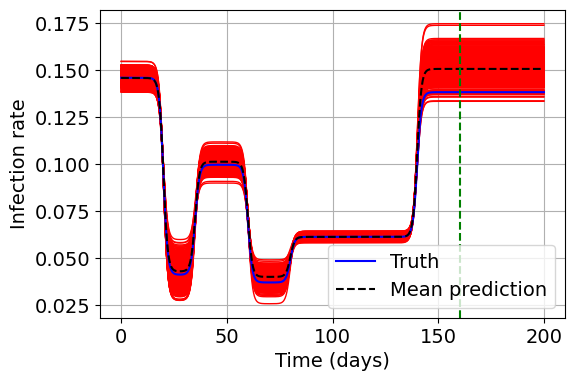

In [14]:
##### Printing beta samples

mpl.rcParams.update({'font.size':14})
fig1, ax1 = plt.subplots(figsize=(6, 4))
# ax1.set_xlim([0,40])
# ax1.set_yticks(np.arange(0, 5000, 50.0))
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Infection rate') 


pred_low = int(tstart*ndiv)

pred_high = int(tlim*ndiv)

Nsamples = 500


for ns in range(Nsamples):


### Toronto
    a0 = samples[0,ns]
    a1 = samples[1,ns]
    t1 =  20
    a2 = samples[2,ns]
    t2 =  35
    a3 =  samples[3,ns]
    t3 = 60
    a4 =  samples[4,ns]
    t4 = 80
    a5 =  samples[5,ns]
    t5 =  140
  


    beta_i[:,0] = a0 + a1/(1 + np.exp((t1-tmoh))) +  a2/(1 + np.exp((t2-tmoh))) + a3/(1 + np.exp((t3-tmoh)))  + a4/(1 + np.exp((t4-tmoh))) + a5/(1 + np.exp((t5-tmoh))) 
                #  + a6/(1 + np.exp((t6-tmoh))) + a7/(1 + np.exp((t7-tmoh))) 
    # + a8/(1 + np.exp((t8-tmoh)))
    beta_e[:,0] = beta_i[:,0]


    ax1.plot(tmoh[pred_low:pred_high], beta_i[pred_low:pred_high,0], color='red', linewidth=1 , label='_nolegend_')


ax1.plot(tmoh[pred_low:pred_high], beta_truth[pred_low:pred_high], color='blue', label='Truth')
ax1.plot(tmoh[pred_low:pred_high], beta_mean[pred_low:pred_high,0], color='black',linestyle='--', label='Mean prediction')
ax1.axvline(x=d_cut, color='g', linestyle='--')
# ax1.set_xticks(np.arange(0,50, 10), labels=['0', '10', '20', '30', '40'])
ax1.legend()
ax1.grid()
ax1.figure.savefig(f'{figpath}/beta_real_uncertainty.pdf', bbox_inches='tight')
plt.show()

(6, 2000)


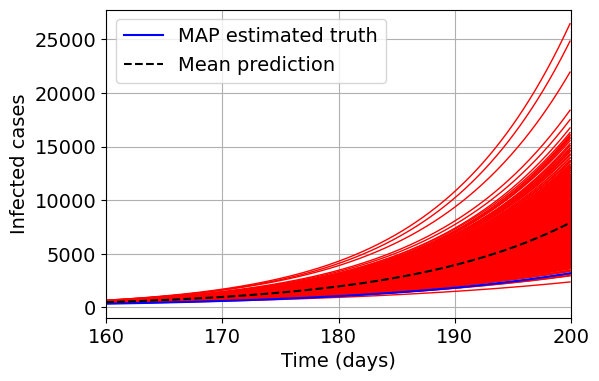

In [17]:

mpl.rcParams.update({'font.size':14})
fig1, ax1 = plt.subplots(figsize=(6, 4))
# ax1.set_xlim([0,40])
# ax1.set_yticks(np.arange(0, 5000, 50.0))
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Infected cases') 


pred_low = int(d_cut*ndiv)

pred_high = int(tlim*ndiv)


print(samples.shape)

Nsamples = 750

for ns in range(Nsamples):


##### For Toronto
    a0 = samples[0,ns]
    a1 = samples[1,ns]
    t1 =  20
    a2 = samples[2,ns]
    t2 =  35
    a3 =  samples[3,ns]
    t3 = 60
    a4 =  samples[4,ns]
    t4 = 80
    a5 =  samples[5,ns]
    t5 =  140


    beta_i[:,0] = a0  + a1/(1 + np.exp((t1-tmoh))) +  a2/(1 + np.exp((t2-tmoh)))  + a3/(1 + np.exp((t3-tmoh)))  + a4/(1 + np.exp((t4-tmoh))) + a5/(1 + np.exp((t5-tmoh)))  \
                #  + a6/(1 + np.exp((t6-tmoh))) + a7/(1 + np.exp((t7-tmoh))) 
    # + a8/(1 + np.exp((t8-tmoh)))
    beta_e[:,0] = beta_i[:,0]


    FoI = np.zeros((len(tmoh),1))
        
    for kk in range(1,len(tmoh)):

        FoI[kk,0] = beta_e[kk-1,0] * (E[kk-1,0] + I[kk-1,0]) / N[kk-1,0]

        S[kk,0] = S[kk-1,0] + dt*(- FoI[kk,0] * S[kk-1,0])
        E[kk,0] = E[kk-1,0] + dt*(FoI[kk,0]*S[kk-1,0] - (gamma_i + gamma_e)*E[kk-1,0])
        
        I[kk,0] = I[kk-1,0] + dt*(gamma_i*E[kk-1,0] - (gamma_r + gamma_d)*I[kk-1,0])
        R[kk,0] = R[kk-1,0] + dt*(gamma_e*E[kk-1,0] + gamma_r*I[kk-1,0])
        D[kk,0] = D[kk-1,0] + dt*(gamma_d*I[kk-1,0])
        N[kk,0] = S[kk,0] +  E[kk,0] + I[kk,0] + R[kk,0]


        


    ax1.plot(tmoh[pred_low:pred_high], I[pred_low:pred_high,0], color='red', linewidth=1 , label='_nolegend_')

    
ax1.plot(tmoh[pred_low:pred_high], I_truth[pred_low:pred_high], color='blue', label='MAP estimated truth')
ax1.plot(tmoh[pred_low:pred_high], I_mean[pred_low:pred_high,0], color='black',linestyle='--', label='Mean prediction')
# ax1.plot(tmoh[pred_low:pred_high], Data[pred_low:pred_high,0], color='black',linestyle='--', label='Mean prediction')
# ax1.axvline(x=210, color='g', linestyle='--', label='data cutoff')
# ax1.set_xticks(np.arange(0,50, 10), labels=['0', '10', '20', '30', '40'])
ax1.set_xlim(d_cut,tlim)
ax1.legend()
ax1.grid()
ax1.figure.savefig(f'{figpath}/predictions_real_200days.pdf', bbox_inches='tight')
plt.show()
    


In [ ]:
###### Plotting PDFS ##########

from scipy.stats import gaussian_kde

x1 = np.linspace(0,1000, 100)

kde = gaussian_kde(I_pdf[0,:], bw_method='scott')

kde_t1 = kde(x1)

fig,ax = plt.subplots(figsize=(6, 4))
plt.plot(x1,kde_t1,label = '160 days')
plt.xlabel('$I$')
plt.ylabel('$p(I)$')
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.savefig(f'{figpath}/pdf_0.pdf',bbox_inches='tight' )
plt.show()


x2 = np.linspace(0,3000, 100)

kde = gaussian_kde(I_pdf[9,:], bw_method='scott')

kde_t2 = kde(x2)

fig,ax = plt.subplots(figsize=(6, 4))
plt.plot(x2,kde_t2,label = '170 days')
plt.xlabel('$I$')
plt.ylabel('$p(I)$')
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.savefig(f'{figpath}/pdf_10.pdf', bbox_inches='tight')
plt.show()



x3 = np.linspace(0,5000, 100)

kde = gaussian_kde(I_pdf[19,:], bw_method='scott')

kde_t3 = kde(x3)

fig,ax = plt.subplots(figsize=(6, 4))
plt.plot(x3,kde_t3,label = '180 days')
plt.xlabel('$I$')
plt.ylabel('$p(I)$')
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.savefig(f'{figpath}/pdf_20.pdf', bbox_inches='tight')
plt.show()




x4 = np.linspace(0,10000, 100)

kde = gaussian_kde(I_pdf[29,:], bw_method='scott')

kde_t4 = kde(x4)

fig,ax = plt.subplots(figsize=(6, 4))
plt.plot(x4,kde_t4,label = '190 days')
plt.xlabel('$I$')
plt.ylabel('$p(I)$')
plt.autoscale(enable=True, axis='x', tight=True)
plt.legend()
plt.savefig(f'{figpath}/pdf_30.pdf', bbox_inches='tight')
plt.show()


